# Model Performance
We can assess the models performance by comparing the AI's predictions to the manual corrections.

## Prerequisites
Install python packages

In [29]:
%%capture
%pip install pandas pydicom pydicom-seg scikit-learn seaborn segmentationmetrics

Import required python packages

In [30]:
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import requests
import zipfile
import io
from pprint import pprint
import numpy as np
import pandas as pd
from typing import Union
import skimage.measure 
from sklearn.metrics import cohen_kappa_score
import pydicom
import pydicom_seg
import SimpleITK as sitk
import segmentationmetrics as sm
from segmentationmetrics.surface_distance import compute_surface_dice_at_tolerance
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
from bubble_chart import BubbleChart
%matplotlib inline


In [31]:
plt_colors = {
    "ne2": "#5eceb0",
    "rad1": "#9e70e1",
    "tp": "k",
    "fp": "b",
    "fn": "r",
}

revewer_cmap = sns.color_palette([plt_colors["ne2"], plt_colors["rad1"]])
vol_cmap = sns.color_palette([plt_colors["tp"], plt_colors["fp"], plt_colors["fn"]])

To compare model performance against the manual corrections, we need to download the dicom-seg files of the ai predictions and the manual corrections from zenodo.

In [32]:
qa_dir = Path("qa-results")


In [33]:
def download_inference(
    extract_dir="qa-results",
    url="https://zenodo.org/record/8400869/files/breast-fdg-pet-ct.zip",
):
    # download the zip file and extract it
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(extract_dir)


if not (qa_dir / "ai-segmentations-dcm").exists():
    download_inference()

## Data Description
The dataset was reviewed by two reviewers, a radiologist and a 'non-expert'. The non-expert was a medical student with some familiarity with radiology images. For this project, the non-expert scored every ai prediction while the radiologist only scored the validation set.

Alone with the segmentation files, we also have a qa-resulst.csv file that gives more information on the quality assessment feedback from the manual reviewers.

| column                      | description                                                                                      |
| --------------------------- | ------------------------------------------------------------------------------------------------ |
| Reviewer                    | Either `rad1` or `ne2` for Radiologist 1 and Non-expert 1 respectively                           |
| Validataion                 | if this scan was in the validation set                                                           |
| Collection                  | IDC collection name                                                                              |
| PatientID                   | PatientID from dicom                                                                             |
| StudyDate                   | StudyDate from dicom                                                                             |
| StudyDate_suffix            | incrementing value to differentiate different scans from the same StudyDate                      |
| StudyInstanceUID            | StudyInstanceUID from dicom                                                                      |
| PTSeriesInstanceUID         | SeriesInstanceUID of PET scan from dicom                                                         |
| CTSeriesInstanceUID         | SeriesInstanceUID of CT scan from dicom                                                          |
| AISegmentation              | filename of ai segmentation                                                                      |
| LikertScore                 | Reviewers opinion of how accurate the AI prediction was, see table below fr                      |
| CommentsAboutAISegmentation | comments from the reviewer about the ai segmentation, usually how the AI underperformed          |
| CommentsAboutScan           | comments from the reviewer about the scan, could be about unusual anatomy or scan artifacts.     |
| CorrectedSegmentation       | file name of the manually corrected segmentation, this file is in `qa-segmentations-dcm`` folder |

The Likert scale used for scoring was:

| Score | Meaning |
| --- | --- |
| 5 | Strongly Agree - Use-as-is (i.e., clinically acceptable, and could be used for treatment without change) |
| 4 | Agree - Minor edits that are not necessary. Stylistic differences, but not clinically important. The current segmentation is acceptable |
| 3 | Neither agree nor disagree - Minor edits that are necessary. Minor edits are those that the review judges can be made in less time than starting from scratch or are expected to have minimal effect on treatment outcome |
| 2 | Disagree - Major edits. This category indicates that the necessary edit is required to ensure correctness, and sufficiently significant that user would prefer to start from the scratch |
| 1 | Strongly disagree - Unusable. This category indicates that the quality of the automatic annotations is so bad that they are unusable.|

Alone with the segmentation files, we also have a `qa-resulst.csv` file that gives more information on the quality assessment feedback from the manual reviewers.

| column | description |
| --- | --- |
| Reviewer| Either `rad1` or `ne2` for Radiologist 1 and Non-expert 2 respectively |
| Validataion | if this scan was in the validation set, roughly 10% of the data |


In [34]:
df = pd.read_csv(
    qa_dir / "qa-results.csv",
    dtype={
        "PatientID": str,
        "StudyDate": str,
        "StudyDate_suffix": str,
        "LikertScore": int,
    },
)
df["CorrectedSegmentation"].fillna("", inplace=True)
# get validation subset
val_df = df[df["Validation"]]
validation_size = len(val_df["CTSeriesInstanceUID"].unique())
total_size = len(df["CTSeriesInstanceUID"].unique())
print(
    f"{validation_size/total_size*100:.2f}% of scans were validated ({validation_size}/{total_size})"
)

# get validation done by different reviewers
rad_df = val_df.loc[(val_df["Reviewer"] == "rad1")]
ne_df = val_df.loc[
    (val_df["Reviewer"] == "ne1")
    | (val_df["Reviewer"] == "ne2")
    & (val_df["AISegmentation"]).isin(rad_df["AISegmentation"])
]

rad_df = rad_df.sort_values(by=["AISegmentation"])
ne_df = ne_df.sort_values(by=["AISegmentation"])

assert len(rad_df) == len(ne_df)
assert len(rad_df) == len(rad_df["AISegmentation"].unique())

print(f"{len(rad_df)} scans were reviewed by radiologist and non-expert")


10.00% of scans were validated (11/110)
11 scans were reviewed by radiologist and non-expert


We caluclate the Cohen-Kappa score between the two reviewers. Cohen-Kappa is a measure of agreement between raters that takes into account the possibility of the agreement occurring by chance. This tells us how much we can trust the scores given by the non-expert reviewer for the portion of the dataset the Radiologist did not review.

Kappa value interpretation Landis & Koch (1977):

| Value     | Interpretation |
| --------- | -------------- |
| <0        | No agreement   |
| 0 — .20   | Slight         |
| .21 — .40 | Fair           |
| .41 — .60 | Moderate       |
| .61 — .80 | Substantial    |
| .81–1.0   | Perfect        |


In [35]:
rad_scores = rad_df.LikertScore.values
ne_scores = ne_df.LikertScore.values
# Calculate Cohen's Kappa
kappa = cohen_kappa_score(rad_scores, ne_scores, labels=[1, 2, 3, 4, 5])

print(f"Cohen's Kappa: {kappa:.2f}")

# Calculate percentage agreement
total_cases = len(rad_scores)
matching_cases = sum(1 for r1, r2 in zip(rad_scores, ne_scores) if r1 == r2)
percentage_agreement = (matching_cases / total_cases) * 100

print(f"Percentage Agreement: {percentage_agreement:.2f}%")


Cohen's Kappa: 0.18
Percentage Agreement: 36.36%


The radiologist and non-expert reviewer only had a fair amount of agreement. From the graph below you can see that the non-expert reviewer was more likely to give a higher score than the radiologist. The radiologist did not give any scores of 5.

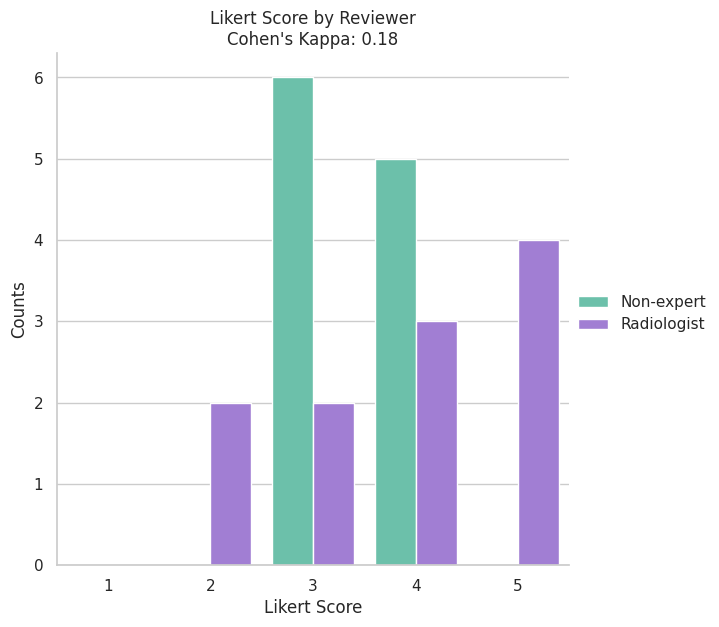

In [36]:
df2 = val_df.groupby(["Reviewer", "LikertScore"]).count()
for reviewer in val_df["Reviewer"].unique():
    for score in range(1, 6):
        if (reviewer, score) not in df2.index:
            df2.loc[(reviewer, score), "SeriesInstanceUID"] = 0

df2.reset_index(inplace=True)
# change rad1 to radiologist
df2.replace({"rad1": "Radiologist", "ne2": "Non-expert"}, inplace=True)

sns.set_palette(revewer_cmap)
g = sns.catplot(
    data=df2,
    kind="bar",
    x="LikertScore",
    y="PTSeriesInstanceUID",
    hue="Reviewer",
    height=6,
    orient="v",
)
# g.despine(left=True)
g.set_axis_labels("Likert Score", "Counts")
g.legend.set_title("")
g.set(title=f"Likert Score by Reviewer\nCohen's Kappa: {kappa:.2f}")

The reviewers also corrected the AI predictions for the validation set when their Likert rating was not 5. We can assess the reviewers agreement with the AI from segmentation metrics of Dice Similarity Coefficient (DSC), 95% Hausdorff distance.

* DSC measures volume similarity between two segmentations.
* 95% Hausdorff distance measures the agreement between surfaces. This is the distance were 95% of points on the surface are within the specified distance of the other surface.

We can also look at the detection accuracty for tumors. Tumor sizes vary and, especially with small tumors, DSC and Hausdorff distance may not be the best metrics to assess the AI's performance. Insteat we can look at the detection rate and false negative & positive volume for the tumor label. Looking at the false negative & positive volume was a metric used by the [AutoPET II](https://autopet-ii.grand-challenge.org/) challenge that the model is based on.

* Detection rate measures the percentage of tumors that were detected by the ai and the reviewer. Any overlap between the ai and reviewer is considered a detection.
* False negative & positive volume measures the volume of the tumors that were detected by the ai or the reviewer. Any overlap between the ai and reviewer is considered a detection and not a false negative or positive.

In [37]:
def load_dcm_seg(seg_path: Path, label=1):
    dcm = pydicom.dcmread(str(seg_path))
    reader = pydicom_seg.MultiClassReader()
    result = reader.read(dcm)
    image = result.image == label
    image = sitk.Cast(image, sitk.sitkUInt8)
    return image


def load_nii_seg(seg_path: Path, label=1):
    img = sitk.ReadImage(str(seg_path))
    img = sitk.Cast(img == label, sitk.sitkUInt8)
    return img


def load_seg(seg_path: Path, label=1):
    if seg_path.suffix == ".dcm":
        return load_dcm_seg(seg_path, label)
    else:
        return load_nii_seg(seg_path, label)


def resize_label(img: sitk.Image, ref_img: sitk.Image, interp=sitk.sitkNearestNeighbor):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_img)
    resampler.SetInterpolator(interp)
    resampler.SetDefaultPixelValue(0)
    resampled_img = resampler.Execute(img)
    return resampled_img


def calc_metrics_for_label(ai_seg_file, qa_seg_file, label_value=1, label_suffix=""):
    ai_img = load_seg(ai_seg_file, label_value)
    qa_img = load_seg(qa_seg_file, label_value)
    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    ai_arr = sitk.GetArrayFromImage(ai_img)
    qa_arr = sitk.GetArrayFromImage(qa_img)
    spacing = ai_img.GetSpacing()[::-1]  # numpy is reversed dimensions from sitk

    qa_img = resize_label(qa_img, ai_img)  # match the size of the ai_img
    m = sm.SegmentationMetrics(ai_arr, qa_arr, spacing)

    metrics = {
        "dice": m.dice,
        "hausdorff_distance_95": m.hausdorff_distance,
        # "mean_surface_distance": m.mean_surface_distance,
        # "mean_surface_distance_tol_7": compute_surface_dice_at_tolerance(
        #     m._surface_dist, 7
        # ),  # from medical segmentation decathlon
    }
    if label_suffix:
        metrics = {f"{k}_{label_suffix}": v for k, v in metrics.items()}
    return metrics


def get_false_discovery(img_file_pred: str, img_file_gt: str, label_value: int = 1):
    """Get the false discovery rate for two images, predicted (image_file_pred) and ground truth (image_file_gt)."""
    img_pred = load_seg(img_file_pred, label_value)
    img_gt = load_seg(img_file_gt, label_value)
    img_gt = resize_label(img_gt, img_pred)  # match the size of the qa_img

    vox_ml = np.prod(img_pred.GetSpacing()) / 1000

    pd_arr = sitk.GetArrayFromImage(img_pred)
    gt_arr = sitk.GetArrayFromImage(img_gt)

    pd_cc = skimage.measure.label(pd_arr)
    gt_cc = skimage.measure.label(gt_arr)
    true_pd_cc = pd_cc.copy()
    true_pd_cc[gt_cc == 0] = 0
    overlap_gt_cc = gt_cc.copy()  # gt labels that overlap with predicted
    overlap_gt_cc[pd_cc == 0] = 0

    pd_labels = np.dstack(np.unique(pd_cc, return_counts=True))[0, 1:]
    gt_labels = np.dstack(np.unique(gt_cc, return_counts=True))[0, 1:]
    true_pd_labels = np.dstack(np.unique(true_pd_cc, return_counts=True))[0, 1:]
    overlap_gt_labels = np.dstack(np.unique(overlap_gt_cc, return_counts=True))[0, 1:]

    true_vol_overlap_ml = true_pd_labels[..., 1] * vox_ml

    # get false positives
    false_pos_vols_ml = []
    for pd_label, pd_size in pd_labels:
        if pd_label not in true_pd_labels[..., 0]:
            false_pos_vols_ml.append(pd_size * vox_ml)

    # get false negatives
    false_neg_vols_ml = []
    for gt_label, gt_size in gt_labels:
        if gt_label not in overlap_gt_labels[..., 0]:
            false_neg_vols_ml.append(gt_size * vox_ml)

    return {
        "true_vol_overlap_ml": true_vol_overlap_ml,
        "false_pos_vols_ml": false_pos_vols_ml,
        "false_neg_vols_ml": false_neg_vols_ml,
        "true_vol_overlap_ml_total": sum(true_vol_overlap_ml),
        "false_pos_vol_ml_total": sum(false_pos_vols_ml),
        "false_neg_vol_ml_total": sum(false_neg_vols_ml),
        "true_vol_overlap_cnt": len(true_vol_overlap_ml),
        "false_pos_cnt": len(false_pos_vols_ml),
        "false_neg_cnt": len(false_neg_vols_ml),
    }


def add_metrics_to_df(df):
    tumor_vols = {}
    for i, row in df.iterrows():
        ai_seg_file = qa_dir / "ai-segmentations-dcm" / row["AISegmentation"]
        if row["LikertScore"] < 5 and row["CorrectedSegmentation"] != "":
            qa_seg_file = qa_dir / "qa-segmentations-dcm" / row["CorrectedSegmentation"]
        else:
            qa_seg_file = ai_seg_file

        assert ai_seg_file.exists(), ai_seg_file
        assert qa_seg_file.exists(), qa_seg_file

        # background is label 1, ignore
        # tumor is label 2

        detection_metrics = get_false_discovery(ai_seg_file, qa_seg_file, label_value=2)
        # extract array values into selerate dict
        tumor_vols[i] = {
            "true_vol_overlap_ml": detection_metrics.pop("true_vol_overlap_ml"),
            "false_neg_vols_ml": detection_metrics.pop("false_neg_vols_ml"),
            "false_pos_vols_ml": detection_metrics.pop("false_pos_vols_ml"),
        }

        metrics = calc_metrics_for_label(ai_seg_file, qa_seg_file, label_value=2)
        metrics["label"] = "tumor"
        metrics.update(detection_metrics)

        # print(metrics)
        # update row i with from metrics
        for k, v in metrics.items():
            df.at[i, k] = v

    return tumor_vols


In [38]:
rad_tumor_vols = add_metrics_to_df(rad_df)
ne_tumor_vols = add_metrics_to_df(ne_df)
rad_df.replace({"rad1": "Radiologist", "ne2": "Non-expert"}, inplace=True)
ne_df.replace({"rad1": "Radiologist", "ne2": "Non-expert"}, inplace=True)

xdf = pd.concat([rad_df, ne_df])


We need to drop the scans that have no tomurs in them for volumetric metrics

In [39]:
vol_df = xdf.dropna(subset=["dice"])

The DSC between reviews varies greatly. The radiologist had a much larger range of disagreement with the AI than the non-expert

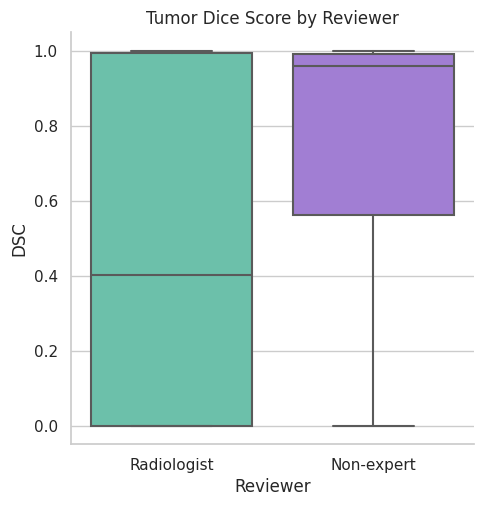

In [40]:
sns.set_palette(revewer_cmap)
g = sns.catplot(data=vol_df, x="Reviewer", y="dice", kind="box")
g.set_axis_labels("Reviewer", "DSC")
g.set(title="Tumor Dice Score by Reviewer")

The 95% Hausdorff distance is less useful, but it shows large disagreement between the radiologist and the ai.

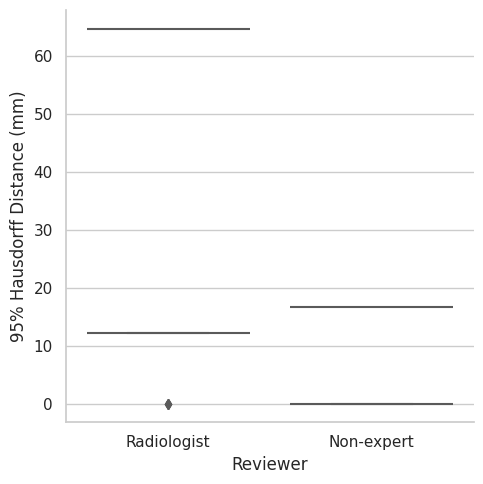

In [41]:
sns.set_palette(revewer_cmap)
g = sns.catplot(data=vol_df, x="Reviewer", y="hausdorff_distance_95", kind="box")
g.set_axis_labels("Reviewer", "95% Hausdorff Distance (mm)")


We can compare the segmentation metrics to the reviewers likert scores. Generally they correlate. There is one interesting case where the reviewer gave a score of 4, but had 0 DSC.

[Text(0.5, 19.049999999999997, 'Likert Score'), Text(37.0, 0.5, 'DSC')]

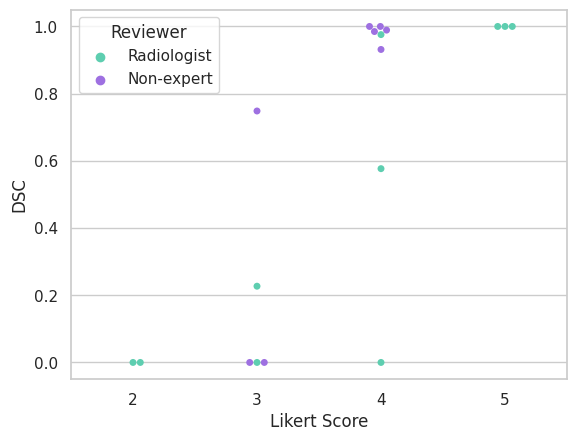

In [42]:
# plot likert score vs dice
sns.set_palette(revewer_cmap)
g = sns.swarmplot(data=vol_df, x="LikertScore", y="dice", hue="Reviewer")
g.set(xlabel="Likert Score", ylabel="DSC")

[Text(0.5, 19.049999999999997, 'Likert Score'),
 Text(41.875, 0.5, '95% Hausdorff Distance (mm)')]

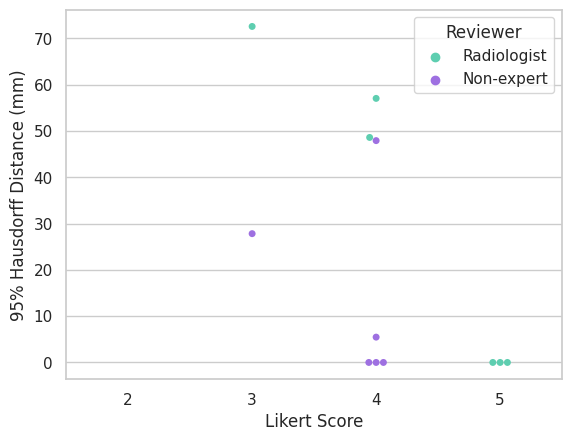

In [43]:
# plot likert score vs dice
sns.set_palette(revewer_cmap)
g = sns.swarmplot(
    data=vol_df, x="LikertScore", y="hausdorff_distance_95", hue="Reviewer"
)
g.set(xlabel="Likert Score", ylabel="95% Hausdorff Distance (mm)")


We can look at the detection metrics to understand how well the AI identified the tumors. We look at the False Positive and False Negative volumes by Likert score. The False Positive and False Negative volumes were used as a metric in the AutoPET II challenge that the model is based on.

In [51]:
# combine false_pos_vol_ml and false_neg_vol_ml into false_vol_ml, add column labet type as pos or neg
pos_df = rad_df[["false_pos_vol_ml_total", "LikertScore"]]
pos_df = pos_df.rename(columns={"false_pos_vol_ml_total": "false_vol_ml"})
pos_df["false_type"] = "false positive"

neg_df = xdf[["false_neg_vol_ml_total", "LikertScore"]]
neg_df = neg_df.rename(columns={"false_neg_vol_ml_total": "false_vol_ml"})
neg_df["false_type"] = "false negative"

false_df = pd.concat([pos_df, neg_df], ignore_index=True)

The graph below shows that generally the false positive and false negative volumes increase as the Likert score decreases.

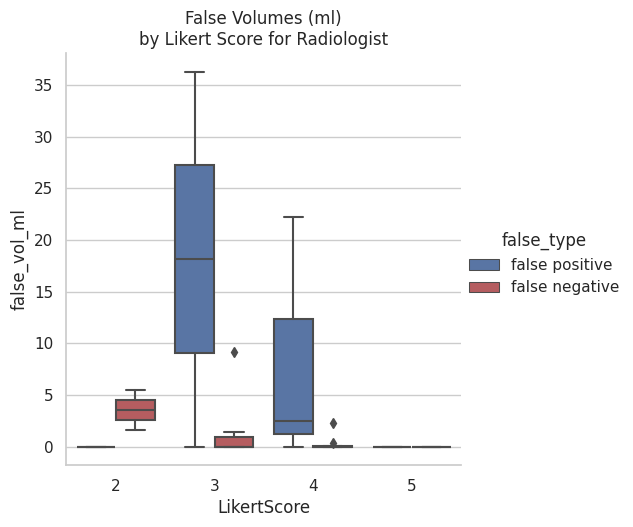

In [53]:
sns.set_palette(sns.color_palette([plt_colors["fp"], plt_colors["fn"]]))
g = sns.catplot(
    data=false_df, x="LikertScore", y="false_vol_ml", hue="false_type", kind="box"
)
g.set(title="False Volumes (ml)\nby Likert Score for Radiologist")


In [56]:
bubble_color_lut = {
    "true_vol_overlap_ml": plt_colors["tp"],
    "false_pos_vols_ml": plt_colors["fp"],
    "false_neg_vols_ml": plt_colors["fn"],
}


def plot_bubble_chart(ax, rad_tumor_vols):
    areas = []
    colors = []
    lbl_names = []

    for k, v in rad_tumor_vols.items():
        areas.extend(v)
        colors.extend([bubble_color_lut[k]] * len(v))
        lbl_names.append("a")

    if len(areas) > 0:
        bubble_chart = BubbleChart(volume=areas, bubble_spacing=0.1)
        bubble_chart.collapse()
        bubble_chart.plot(ax, colors=colors)
    else:
        bubble_chart = None

    ax.relim()
    ax.autoscale_view()
    return bubble_chart

In [57]:
def match_scale(ax):
    x_max_width = 0
    y_max_width = 0
    for x in ax.flat:
        ylim = x.get_ylim()
        ycenter = (ylim[1] + ylim[0]) / 2
        ywidth = ylim[1] - ylim[0]
        if ywidth > y_max_width:
            y_max_width = ywidth

        xlim = x.get_xlim()
        xcenter = (xlim[1] + xlim[0]) / 2
        xwidth = xlim[1] - xlim[0]
        if xwidth > x_max_width:
            x_max_width = xwidth

    # set widths to max width centered on center
    for i, x in enumerate(ax.flat, start=1):
        ylim = x.get_ylim()
        ycenter = (ylim[1] + ylim[0]) / 2
        x.set_ylim(ycenter - y_max_width / 2, ycenter + y_max_width / 2)

        xlim = x.get_xlim()
        xcenter = (xlim[1] + xlim[0]) / 2
        x.set_xlim(xcenter - x_max_width / 2, xcenter + x_max_width / 2)

        x.set_xticks([])
        x.set_yticks([])
        x.set_title(f"Case {i}")

The figure below looks at each case in the validation set. Each circle represents a tumor in that case with the size correlated to the tumor volume. The color indicates if it was a true posivite, false positive, or false negative. In five of the cases, the AI predicted nothing, but missed the tumors in the 4 of the scans. The other 6 scans were mixed weith the AI getting some correct if there was only 1 true tumor, but other cases had false positives and negatives.

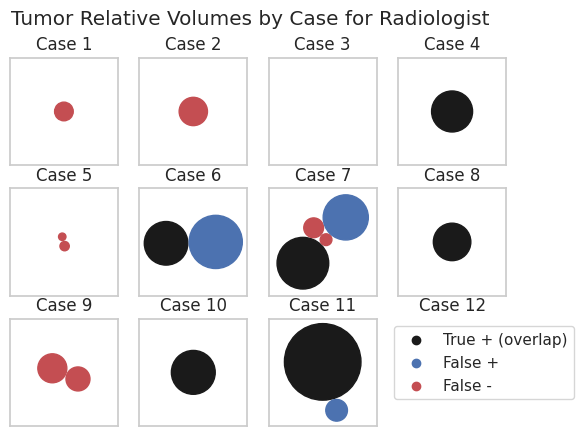

In [58]:
# sns.set_palette(vol_cmap)
fig, ax = plt.subplots(3, 4, subplot_kw=dict(aspect="equal"))
fig.suptitle("Tumor Relative Volumes by Case for Radiologist")

for i, v in enumerate(rad_tumor_vols.values()):
    plot_bubble_chart(ax.flat[i], v)

match_scale(ax)  # so plots are comparable

# dummy plot for the legend
labels = ["True + (overlap)", "False +", "False -"]
for label, color in zip(labels, bubble_color_lut.values()):
    ax.flat[-1].scatter([-100], [-100], c=color, label=label)
ax.flat[-1].axis("off")
plt.legend(
    # loc="lower right",
    bbox_to_anchor=(1.2, 0.5, 0.5, 0.5),
)
